## import

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io
import re

from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

from scipy import io

In [8]:
import os

import nibabel as nib
from nilearn.datasets import fetch_surf_fsaverage

import brainstat
from brainstat.stats.terms import FixedEffect

import pandas as pd

import scipy as sp
import scipy.stats
from scipy import stats

from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [9]:
import sys , numpy as np
mod = sys.modules[__name__]

## load cortex files

In [10]:
from glob import glob
path = './data/schaefer200/cortex/'
filepaths = glob(path+'*.csv') # load path of csv files

In [11]:
import pandas as pd
for i in range(len(filepaths)):
    dat = pd.read_csv(filepaths[i], header=None)
    res = re.split('[\\\/]',filepaths[i])
    globals()[res[-1][:-4]+'_a'] = dat.to_numpy() # load csv files as numpy type

In [12]:
for i in range(1,100+1):
    globals()['ctx{}'.format(i)] = getattr(mod,'g{}_200_a'.format(i))

### make cortico-cortical connectivity matrix

In [13]:
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure 
correlation_measure = ConnectivityMeasure(kind='correlation')

for i in range(1,100+1):
    globals()['ctx{}_c'.format(i)] = correlation_measure.fit_transform([getattr(mod, 'ctx{}'.format(i))]) 

In [14]:
for i in range(1, 100+1):
    globals()['ctx{}_c'.format(i)] = getattr(mod, 'ctx{}_c'.format(i))[0]
# (1,200,200) array shape -> (200,200) array shape

### 1. z-transformation
### 2. transform all diagonals into zeros

In [15]:
tab = np.zeros(shape=(200,200))

In [16]:
for i in range(1,101):
    tab = np.arctanh(getattr(mod, 'ctx{}_c'.format(i)))
    np.fill_diagonal(tab, np.zeros(200))
    globals()['ctx{}_cz'.format(i)] = tab

C:\Users\chlee\AppData\Local\Temp\ipykernel_8228\648496427.py:2: RuntimeWarning: divide by zero encountered in arctanh
  tab = np.arctanh(getattr(mod, 'ctx{}_c'.format(i)))


### get group connectivity matrix averaging z-transformed 100 connectivity matrix

In [17]:
import numpy
ctx_sum = numpy.zeros(shape=(200,200))
for i in range(1,101):
    ctx_sum = ctx_sum + getattr(mod, 'ctx{}_cz'.format(i))

In [18]:
ctx_mean = ctx_sum/100 

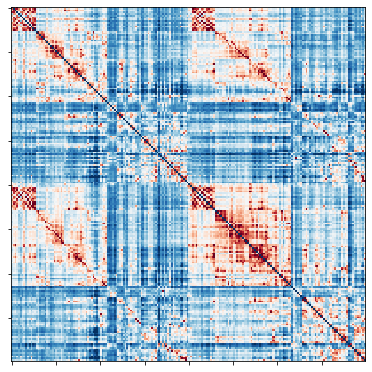

In [21]:
plotting.plot_matrix(ctx_mean, vmin=0, vmax=1,colorbar=False) # we get group connectivity matrix of 100 individual connectivity matrices

## make gradient (henceforth eigenvector)

In [19]:
labeling = load_parcellation('schaefer', scale=200, join=True)
mask = labeling != 0
# generate labeing and mask based on schaefer200

In [20]:
surf_lh, surf_rh = load_conte69()

### make eigenvectors of group connectivity matrix

In [21]:
gradients_kernel = [None] * 3 

gm = GradientMaps(kernel='normalized_angle', approach='dm', random_state=0)
gm.fit(ctx_mean) 
    
for i in range(0,2+1):
    gradients_kernel[i] = map_to_labels(gm.gradients_[:,i], labeling, mask=mask,
                                       fill=np.nan)

label_text = ['eigenvector1','eigenvector2','eigenvector3']
plot_hemispheres(surf_lh, surf_rh, array_name=gradients_kernel, size=(1200,600),
                cmap='viridis', color_bar=True, label_text=label_text, zoom=1.45, color_range = (-0.1,0.1)) 

### make template of eigenvectors 1,2 and 3 with hcp

In [22]:
mat_file_name = "./data/gradients_FC.mat"
mat_file = scipy.io.loadmat(mat_file_name)

In [23]:
gm_mean = mat_file['gm_mean']

In [24]:
gradients_kernel = [None] * 3 

gm = GradientMaps(kernel='normalized_angle', approach='dm', random_state=0) 

for i in range(0,2+1):
    gradients_kernel[i] = map_to_labels(gm_mean[:,i], labeling, mask=mask,
                                       fill=np.nan)

label_text = ['eigenvector1','eigenvector2','eigenvector3']
plot_hemispheres(surf_lh, surf_rh, array_name=gradients_kernel, size=(1200,600),
                cmap='viridis', color_bar=True, label_text=label_text, zoom=1.45, color_range = (-0.1,0.1)) 

### align group connectivity matrix with hcp eigenvectors

In [25]:
# eigenvector alignment
align = GradientMaps(kernel='normalized_angle', approach='dm', alignment='procrustes', n_components = 5)

align.fit(ctx_mean, reference = gm_mean)

GradientMaps(alignment='procrustes', kernel='normalized_angle', n_components=5)

In [26]:
gradients_kernel = [None] * 3 
for i in range(0,2+1):
    gradients_kernel[i] = map_to_labels(align.aligned_[:, i], labeling, mask=mask,
                                       fill=np.nan)

    
label_text = ['Eigenvector1','Eigenvector2','Eigenvector3']
plot_hemispheres(surf_lh, surf_rh, array_name=gradients_kernel, size=(1200,600),
                cmap='viridis', color_bar=False, label_text=label_text, zoom=1.45, color_range = (-0.1, 0.1)) 

### align each individual connectivity matrix with hcp-aligned group connectivity matrix

> we call it individual eigenvector

In [27]:
for i in range(1,100+1):
    align2 = GradientMaps(kernel='normalized_angle', approach='dm', alignment='procrustes', n_components = 5)
    align2.fit(getattr(mod,'ctx{}_cz'.format(i)), reference = align.aligned_)
    globals()['grad_{}'.format(i)] = align2.aligned_[:,0:2+1]

## Multivariate analysis

> we perform multivariate analysis with 100 individual eigenvectors

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

brain = pd.read_excel("./data/환자군_정상군_181104_결측값업데이트_scores2_bypark.xlsx")

In [29]:
brain

,Unnamed: 0,Unnamed: 1,n,No,group,이름,Sex,Age,Ictal,ID,...,MIBS_total,Interictal_시각_total,Premonitory_시각_total,Ictal_시각_total,HADS_D,HADS_A,PHQ_total,onset_yr,HA_freq_m_fMRI,HA_days
0,1,grp1_pat01,108,P-01,1,박정란,0,39,1,18448615,...,8.0,5,5.0,28.0,9,7,3.0,NaN,3.5,NaN
1,2,grp1_pat02,112,P-02,1,최은미,0,44,0,38155304,...,6.0,2,2.0,20.0,13,8,10.0,10.0,2.0,4.0
2,3,grp1_pat03,148,P-07,1,최우진,1,32,1,34329817,...,12.0,3,4.0,9.0,10,9,7.0,12.0,3.0,5.0
3,4,grp1_pat04,134,P-05,1,이경하,1,29,1,34912684,...,5.0,9,9.0,9.0,11,5,8.0,NaN,9.0,7.0
4,5,grp1_pat05,160,P-09,1,김효선,0,46,0,22894974,...,0.0,1,6.0,20.0,2,1,1.0,25.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,grp2_nor46,102,C-51,0,김묘경,0,50,1,16304203,...,NaN,8,NaN,NaN,2,1,NaN,NaN,NaN,NaN
96,97,grp2_nor47,100,C-50,0,정현희,0,39,0,14815059,...,NaN,10,NaN,NaN,9,4,NaN,NaN,NaN,NaN
97,98,grp2_nor48,70,C-35,0,최수진,0,20,1,39855656,...,NaN,4,NaN,NaN,4,6,NaN,NaN,NaN,NaN
98,99,grp2_nor49,98,C-49,0,윤선영,0,35,1,22124840,...,NaN,13,NaN,NaN,2,3,NaN,NaN,NaN,NaN


make sex and grp as dummy variables

In [30]:
age = brain['Age']

sex = brain['Sex']
sex=np.array(sex)
sex=sex.reshape(100,1)

grp = brain['group']
grp=np.array(grp)
grp=grp.reshape(100,1)

NumSubj = np.size(grp)

In [31]:
sex_dum1 = np.zeros((NumSubj,1))
sex_dum1 = np.where(sex==0, 1, sex_dum1)

sex_dum2 = np.zeros((NumSubj,1))
sex_dum2 = np.where(sex==1, 1, sex_dum2)

sex_dum = np.concatenate((sex_dum1, sex_dum2), axis=1) # F,M

In [32]:
grp_dum1 = np.zeros((NumSubj,1))
grp_dum1 = np.where(grp==0, 1, grp_dum1)

grp_dum2 = np.zeros((NumSubj, 1))
grp_dum2 = np.where(grp==1, 1, grp_dum2)

grp_dum = np.concatenate((grp_dum1, grp_dum2), axis=1) # ctl pat

In [33]:
# get brainstat dir
brainstat_dir = os.path.dirname(brainstat.__file__)

define model

In [34]:
# from brainstat.stats.terms import FixedEffect

term_age = FixedEffect(age, "age")
term_sex = FixedEffect(sex_dum, {"F", "M"})
term_grp = FixedEffect(grp_dum, {"ctl", "pat"})

model = term_age + term_sex + term_grp

model

,intercept,age,M,F,ctl,pat
0,1,39,1.0,0.0,0.0,1.0
1,1,44,1.0,0.0,0.0,1.0
2,1,32,0.0,1.0,0.0,1.0
3,1,29,0.0,1.0,0.0,1.0
4,1,46,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
95,1,50,1.0,0.0,1.0,0.0
96,1,39,1.0,0.0,1.0,0.0
97,1,20,1.0,0.0,1.0,0.0
98,1,35,1.0,0.0,1.0,0.0


append 200x3 matrices of 100 individuals by 3d array

In [35]:
Z = np.dstack([grad_1,grad_2])

for i in range(3,100+1):
    Z = np.dstack([Z, getattr(mod, 'grad_{}'.format(i))])

In [36]:
NumROI = 200

In [37]:
data = np.zeros((NumSubj, NumROI, 3))

for ns in range(0,NumSubj):
    mat = Z[:,:,ns]
    data[ns,:,:] = mat

In [38]:
from brainstat.stats.SLM import SLM

contrast = grp_dum[:,0] - grp_dum[:,1]
slm = SLM(model, contrast, correction="fdr")
slm.fit(data)

when we put contrast = patient groups - normal controls, we get t-values of these contrasts

In [39]:
slm.t

array([[2.14876103, 1.23186571, 3.12476075, 1.92518485, 1.95904819,
        3.39230119, 2.78195211, 1.6217462 , 0.78672987, 2.60300912,
        1.67177175, 1.63802031, 1.48959521, 0.30324139, 2.44473167,
        1.58025548, 2.08427581, 1.57246564, 2.61300185, 2.3043656 ,
        1.32283402, 1.43303737, 1.39847783, 3.35928534, 1.09629441,
        1.55050335, 1.51088932, 2.93119455, 1.99455004, 2.30888821,
        3.26062455, 2.316518  , 2.62426723, 1.85550358, 1.23774366,
        2.44618028, 2.42998781, 3.19399333, 2.11057079, 1.05533982,
        1.16205301, 2.36243894, 3.32433216, 1.86276838, 0.55875263,
        2.1272764 , 2.53680982, 1.77572975, 0.96535913, 1.85895688,
        1.04059509, 2.42195584, 1.79071038, 2.58530215, 1.8555495 ,
        1.28948764, 2.95795313, 3.5265642 , 2.37801895, 2.15374232,
        0.57181577, 1.4125735 , 1.26812938, 0.85087741, 1.56260274,
        2.70899759, 1.51460081, 1.06539731, 2.59570729, 1.79732002,
        1.38070694, 0.82210246, 1.12505329, 2.22

we save t-values of group differences in cortical eigenvectors for future correlation analysis with neurotransmitter distribution

In [40]:
pd.DataFrame([slm.t[0]]).T.to_csv("./fig1/total_t_value.csv", header=False, index=False)

we will get p-values

In [41]:
rv = sp.stats.t(df=slm.df)
cdf = rv.cdf(slm.t)
pval = 1-cdf

In [42]:
pval

array([[1.70843385e-02, 1.10504060e-01, 1.17686239e-03, 2.85830892e-02,
        2.65041737e-02, 5.04043823e-04, 3.25268804e-03, 5.40687948e-02,
        2.16688934e-01, 5.35318686e-03, 4.89129587e-02, 5.23455855e-02,
        6.98044080e-02, 3.81181040e-01, 8.15994233e-03, 5.86688688e-02,
        1.98952907e-02, 5.95663670e-02, 5.20943456e-03, 1.16787935e-02,
        9.45165173e-02, 7.75478976e-02, 8.25959052e-02, 5.61047960e-04,
        1.37846241e-01, 6.21556472e-02, 6.70506941e-02, 2.11018555e-03,
        2.44638849e-02, 1.15472713e-02, 7.69557690e-04, 1.13283487e-02,
        5.05156468e-03, 3.32962939e-02, 1.09414901e-01, 8.12919175e-03,
        8.47887527e-03, 9.49240286e-04, 1.87042323e-02, 1.46959324e-01,
        1.24047409e-01, 1.00864947e-02, 6.27960925e-04, 3.27763278e-02,
        2.88815796e-01, 1.79799812e-02, 6.39942981e-03, 3.94730859e-02,
        1.68395272e-01, 3.30482752e-02, 1.50338583e-01, 8.65725439e-03,
        3.82458438e-02, 5.61673629e-03, 3.32929855e-02, 1.001633

we will get corrected p-values

In [43]:
# two-tailed
pval = stats.t.sf(np.abs(slm.t), slm.df)*2

from  statsmodels.stats import multitest
pcor = multitest.fdrcorrection(pval.ravel())

In [44]:
pcor[1]

array([0.10806629, 0.2966552 , 0.031383  , 0.14291545, 0.13591884,
       0.023694  , 0.05913978, 0.19562077, 0.46599771, 0.07747222,
       0.19371469, 0.19562077, 0.22208573, 0.76236208, 0.09112899,
       0.20767741, 0.11208614, 0.2090048 , 0.07747222, 0.09317163,
       0.27004719, 0.23860892, 0.25029062, 0.023694  , 0.34036109,
       0.21069711, 0.21983834, 0.04442496, 0.12834105, 0.09317163,
       0.023694  , 0.09317163, 0.07747222, 0.15668844, 0.29571595,
       0.09112899, 0.09112899, 0.02712115, 0.10806629, 0.35037462,
       0.32012235, 0.09317163, 0.023694  , 0.15668844, 0.59858196,
       0.10806629, 0.08532573, 0.16977671, 0.38271653, 0.15668844,
       0.35373784, 0.09112899, 0.16628628, 0.07747222, 0.15668844,
       0.278365  , 0.04332202, 0.023694  , 0.09231853, 0.10806629,
       0.5924826 , 0.24582428, 0.28664634, 0.43862409, 0.20937362,
       0.06949895, 0.21983834, 0.34863665, 0.07747222, 0.16577804,
       0.25270401, 0.44929705, 0.33010284, 0.1058568 , 0.19462

return significant indexes of t-values under corrected p-values < 0.055

In [45]:
sig_idx = np.where(pcor[1]<0.055)

In [46]:
tot_t = slm.t.T
sig_t = np.zeros((200,1))
sig_t[sig_idx] = tot_t[sig_idx]

In [47]:
sig_t

array([[0.        ],
       [0.        ],
       [3.12476075],
       [0.        ],
       [0.        ],
       [3.39230119],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [3.35928534],
       [0.        ],
       [0.        ],
       [0.        ],
       [2.93119455],
       [0.        ],
       [0.        ],
       [3.26062455],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [3.19399333],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [3.32433216],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

import maximum value among significant values

In [ ]:
np.max(sig_t)

we only plot significant regions onto brain surface 

In [ ]:
data = [None]*1
data[0] = map_to_labels(sig_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['sig_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

## visualization

### radar chart

classify 200 nodes into 7 networks

In [ ]:
Vis_idx = list(range(1-1,14+1-1)) + list(range(101-1,115+1-1))
SomMot_idx = list(range(15-1,30+1-1)) + list(range(116-1,134+1-1))
DorsAttn_idx = list(range(31-1,43+1-1)) + list(range(135-1,147+1-1))
SalVentAttn_idx = list(range(44-1,54+1-1)) + list(range(148-1,158+1-1))
Limbic_idx = list(range(55-1,60+1-1)) + list(range(159-1,164+1-1))
Cont_idx = list(range(61-1,73+1-1)) + list(range(165-1,181+1-1))
Default_idx = list(range(74-1,100+1-1)) + list(range(182-1,200+1-1))

In [ ]:
Vis_m = np.mean(tot_t[Vis_idx])
SomMot_m = np.mean(tot_t[SomMot_idx])
DorsAttn_m = np.mean(tot_t[DorsAttn_idx])
SalVentAttn_m = np.mean(tot_t[SalVentAttn_idx])
Limbic_m = np.mean(tot_t[Limbic_idx])
Cont_m = np.mean(tot_t[Cont_idx])
Default_m = np.mean(tot_t[Default_idx])

In [ ]:
df = pd.DataFrame({
    'Visual': [Vis_m],
    'Somatomotor': [SomMot_m],
    'Dorsal attention': [DorsAttn_m],
    'Ventral attention': [SalVentAttn_m],
    'Limbic': [Limbic_m],
    'Frontoparietal': [Cont_m],
    'Default mode': [Default_m]
})

In [ ]:
y = df.values[0]
y = numpy.concatenate((y,y[0]),axis=None)

make spider-plot

In [ ]:
labels = df.columns[:]
num_labels = len(labels)

labels = ['','','','','','','']

angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] 
angles += angles[:1] 


fig = plt.figure(figsize=(5,5))
# fig.set_facecolor('white')
 
    
ax = plt.subplot(polar=True)
ax.set_theta_offset(pi / 2) ## starting point
ax.set_theta_direction(-1) ## direction
    
plt.xticks(angles[:-1], labels, fontsize=13) ## x-ticks label
ax.tick_params(axis='x', which='major', pad=15) ## make empty spaces between x-axes and ticks
 
ax.set_rlabel_position(0) ## y-axis degree
plt.yticks([1,1.5,2,2.5],['1','1.5','2','2.5'], fontsize=20) ## y-ticks
plt.ylim(1,2.5)
    
ax.plot(angles, y, linewidth=2, linestyle='solid', color='black') ## print spider-plot     

return values of spider plot

In [ ]:
df

we make network-wide brain surfaces to append spider-plot labels.

In [ ]:
Vis_t = np.zeros((200,1))
Vis_t[Vis_idx] = tot_t[Vis_idx]

SomMot_t = np.zeros((200,1))
SomMot_t[SomMot_idx] = tot_t[SomMot_idx]

DorsAttn_t = np.zeros((200,1))
DorsAttn_t[DorsAttn_idx] = tot_t[DorsAttn_idx]

SalVentAttn_t = np.zeros((200,1))
SalVentAttn_t[SalVentAttn_idx] = tot_t[SalVentAttn_idx]

Limbic_t = np.zeros((200,1))
Limbic_t[Limbic_idx] = tot_t[Limbic_idx]

Cont_t = np.zeros((200,1))
Cont_t[Cont_idx] = tot_t[Cont_idx]

Default_t = np.zeros((200,1))
Default_t[Default_idx] = tot_t[Default_idx]

In [ ]:
data = [None]*1
data[0] = map_to_labels(Vis_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['Vis_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(Vis_t)), zoom=1)

In [ ]:
data = [None]*1
data[0] = map_to_labels(SomMot_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['SomMot_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

In [ ]:
data = [None]*1
data[0] = map_to_labels(DorsAttn_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['DorsAttn_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

In [ ]:
data = [None]*1
data[0] = map_to_labels(SalVentAttn_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['SalVentAttn_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

In [ ]:
data = [None]*1
data[0] = map_to_labels(Limbic_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['Limbic_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

In [ ]:
data = [None]*1
data[0] = map_to_labels(Cont_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['Cont_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

In [ ]:
data = [None]*1
data[0] = map_to_labels(Default_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['Default_t']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,np.max(sig_t)), zoom=1)

not only significant regions, but also all regions

In [ ]:
data = [None]*1
data[0] = map_to_labels(tot_t[:,0], labeling, mask=mask, fill=np.nan)


label_text = ['whole t_value']
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200,600),
                cmap='Reds', color_bar=False, label_text=label_text, color_range=(0,4), zoom=1)

### scree plot

we make scree plot of eigenvectors

In [ ]:
ctx_df = pd.DataFrame(ctx_mean)

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.StandardScaler()

In [ ]:
scaled_sum = ctx_mean.copy()

In [ ]:
scaled_sum = pd.DataFrame(scaler.fit_transform(scaled_sum))                         

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=5)

In [ ]:
Principal_components = pca.fit_transform(scaled_sum)

In [ ]:
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5'])

In [ ]:
print(pca_df)

In [ ]:
pca_fit = pca.fit(scaled_sum)

In [ ]:
PC_values = np.arange(pca.n_components_) + 1

In [ ]:
# Scree plot

fig = plt.figure(figsize=(7,5))
fig.set_facecolor('white')

plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2, color='black')
plt.xticks([1,2,3,4,5])
plt.xlabel('Component number')
plt.ylabel('Scaled eigenvalues')
plt.show()
# plt.axis([0,5,0,3])

we check explained portion

In [ ]:
pca.explained_variance_ratio_

In [ ]:
print("Proportion of Variance Explained : ",
     pca.explained_variance_ratio_.round(2))

out_sum = np.cumsum(pca.explained_variance_ratio_).round(2)
print("Cumulative Prop. Variance Explained", out_sum)

### yeo17 atlas for functional connectivity schema

Load atlases

In [ ]:
from nilearn.maskers import NiftiMasker
from nilearn.input_data import NiftiMasker

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

In [ ]:
from nilearn import datasets
yeo = datasets.fetch_atlas_yeo_2011()

In [ ]:
data = datasets.fetch_development_fmri(n_subjects=50)

extract coordinates on atlas - parcellation

In [ ]:
connectome_measure = ConnectivityMeasure(kind='correlation')

from nilearn import plotting

masker = NiftiLabelsMasker(labels_img=yeo['thick_17'],standardize=True,memory='nilearn_cache')

In [ ]:
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

In [ ]:
correlation_matrices = connectome_measure.fit_transform(time_series)

In [ ]:
mean_correlation_matrix = connectome_measure.mean_

In [ ]:
coordinates_l = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'], label_hemisphere='left')

In [ ]:
coordinates_r = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'], label_hemisphere='right')

In [ ]:
plotting.plot_connectome(mean_correlation_matrix, coordinates_l,
                        edge_threshold="80%", annotate=False)
# plt.savefig('./fig1/yeo17_left.png')

In [ ]:
plotting.plot_connectome(mean_correlation_matrix, coordinates_r,
                        edge_threshold="80%", annotate=False)
# plt.savefig('./fig1/yeo17_right.png')